In [1]:
#============================================================
# Reservoir Computing (DSNN) for MNIST digit classification using Lorenz Reservoirs
#============================================================
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import time

# ================== CONFIGURATIONS ======================
np.random.seed(42)
N = 1500  # Number of reservoirs
param_range_reservoir = [(0.195, 0.205), (0.195, 0.205), (5.65, 5.75)] # chaotic
# param_range_reservoir = [(0.02, 0.07),  (0.02, 0.07),  (6.0, 7.0)]   # far stable
tau_range = (0.8, 2.0)   # safe timescale range

t_initial, t_final = 0, 2
num_eval_points = 20  # Reduce to save time

# ================== LOAD MNIST DATA ======================
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=20000, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=2000, shuffle=False)

# Get first batch (you can loop for more)
train_images, train_labels = next(iter(train_loader))
test_images, test_labels = next(iter(test_loader))

# Flatten images
train_images = train_images.view(train_images.size(0), -1).numpy()  # (1000, 28*28)
test_images = test_images.view(test_images.size(0), -1).numpy()

# ============ NORMALIZE INPUT DATA ============
scaler_input = StandardScaler()
train_input_norm = scaler_input.fit_transform(train_images).T  # (784, 1000)
test_input_norm = scaler_input.transform(test_images).T

M, D_train = train_input_norm.shape  # M=784, D_train=1000
D_test = test_input_norm.shape[1]

# ============ GENERATE RANDOM PARAMETERS ============
# Random reservoir parameters
reservoir_params = np.array([
    [np.random.uniform(low, high) for low, high in param_range_reservoir] +
    [np.random.uniform(*tau_range)]
    for _ in range(N)
])

# ============ BUILD RANDOM WEIGHT MATRIX R ============
R = np.random.uniform(-1, 1, size=(3*N, M))

# ============ DEFINE LORENZ SYSTEM ============
def lorenz_system(t, X, params):
    X = X.reshape(N, 3)
    dxdt = (1 / params[:, 3]) * params[:, 0] * (X[:, 1] - X[:, 0])
    dydt = (1 / params[:, 3]) * (X[:, 0] * (params[:, 1] - X[:, 2]) - X[:, 1])
    dzdt = (1 / params[:, 3]) * (X[:, 0] * X[:, 1] - params[:, 2] * X[:, 2])
    dXdt = np.stack([dxdt, dydt, dzdt], axis=1).flatten()
    return dXdt

# ============ RESERVOIR COMPUTATION ============
def run_reservoir(input_data_norm, D):
    intermediate_results = np.zeros((3 * N, D))
    for i in range(D):
        input_vector = np.dot(R, input_data_norm[:, i]).flatten()
        t_eval = np.linspace(t_initial, t_final, num_eval_points)
        sol = solve_ivp(
            lorenz_system, (t_initial, t_final), input_vector,
            t_eval=t_eval, args=(reservoir_params,), method='RK45', rtol=1e-6, atol=1e-9
        )
        intermediate_results[:, i] = sol.y[:, -1]
    return intermediate_results  # (3N, D)


In [2]:
start_time = time.time()

print("Running reservoir on training data...")
X_train = run_reservoir(train_input_norm, D_train)
print("Running reservoir on test data...")
X_test = run_reservoir(test_input_norm, D_test)



Running reservoir on training data...
Running reservoir on test data...


In [3]:
# Save to .npy files
np.save('X_train_reservoir_rossler_10000i_b.npy', X_train)
np.save('X_test_reservoir_rossler_10000i_b.npy', X_test)

print("Reservoir outputs saved as .npy files.")

Reservoir outputs saved as .npy files.


In [4]:
X_train = np.load('X_train_reservoir_rossler_10000i_b.npy')
X_test = np.load('X_test_reservoir_rossler_10000i_b.npy')

In [5]:
# ============ CLASSIFIER (LOGISTIC REGRESSION) ============
clf = LogisticRegression(max_iter=10000)
clf.fit(X_train.T, train_labels.numpy())

# ============ PREDICT & EVALUATE ============
train_pred = clf.predict(X_train.T)
test_pred = clf.predict(X_test.T)

train_acc = accuracy_score(train_labels.numpy(), train_pred)
test_acc = accuracy_score(test_labels.numpy(), test_pred)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy: {test_acc:.3f}")

end_time = time.time()
print(f"Total Execution Time: {end_time - start_time:.2f} seconds")

Train Accuracy: 1.000
Test Accuracy: 0.874
Total Execution Time: 1402.30 seconds


In [6]:
import pandas as pd

# Save training predictions
train_df = pd.DataFrame({
    "True_Label": train_labels.numpy(),
    "Predicted_Label": train_pred
})
train_df.to_csv("train_predictions_MNIST_rossler_i_b.csv", index=False)

# Save test predictions
test_df = pd.DataFrame({
    "True_Label": test_labels.numpy(),
    "Predicted_Label": test_pred
})
test_df.to_csv("test_predictions_MNIST_rossler_i_b.csv", index=False)

print("✅ Train and Test Predictions Saved")


✅ Train and Test Predictions Saved


In [7]:
# Load the prediction labels
pred_df = pd.read_csv("test_predictions_MNIST_rossler_i_b.csv")
true_labels = pred_df["True_Label"].values
pred_labels = pred_df["Predicted_Label"].values


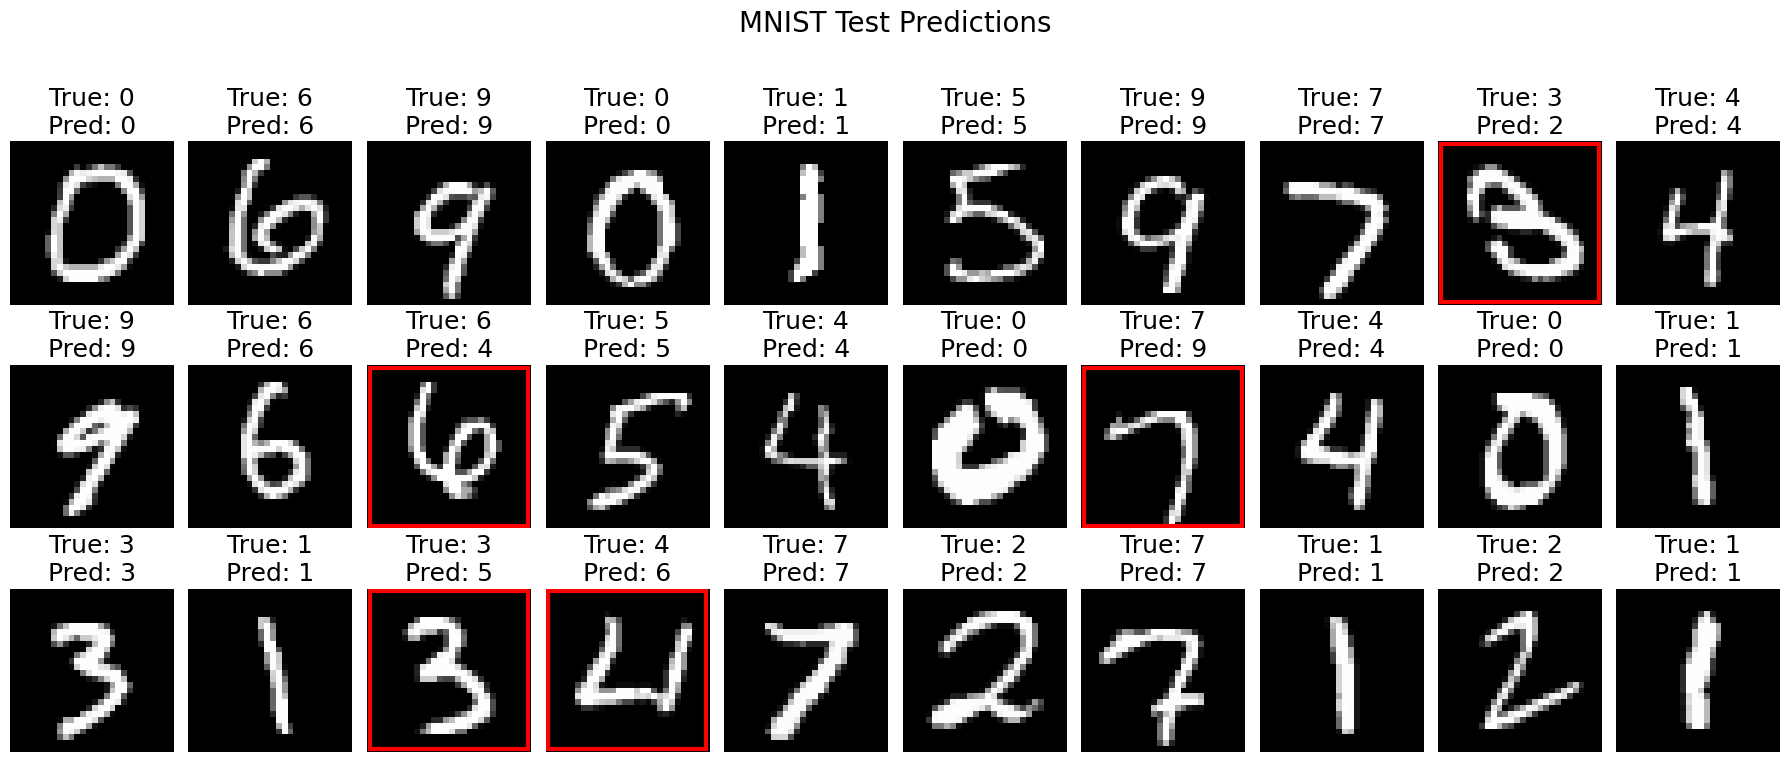

✅ Image Saved


In [8]:
import matplotlib.patches as patches

# Show 30 examples starting from some index
start_idx = 10
num_show = 30

plt.figure(figsize=(18, 8))  # Wider and slightly shorter for better spacing

for i in range(num_show):
    idx = start_idx + i
    ax = plt.subplot(3, 10, i + 1)
    ax.imshow(test_images[idx].reshape(28, 28), cmap='gray')
    ax.set_title(f"True: {test_labels[idx]}\nPred: {test_pred[idx]}", fontsize=18)
    ax.axis('off')

    # Add red rectangle if prediction is incorrect
    if test_pred[idx] != test_labels[idx]:
        rect = patches.Rectangle((0, 0), 27, 27, linewidth=3, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

plt.suptitle("MNIST Test Predictions", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.95])  # Leave space for title

# Save the figure with high resolution
plt.savefig(f"mnist_test_predictions_rossler_i_b_{start_idx}.png", dpi=300, bbox_inches='tight')

plt.show()
print("✅ Image Saved")
